In [5]:
# import standard libs
from pathlib import PurePath, Path
import sys
import time
import timeit
from collections import OrderedDict as od
import re
import os
import json
import requests

# import python scientific stack
import itertools
import pandas as pd
import numpy as np
from numba import jit
import math
import ffn
import pyfolio as pf

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score

import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import squareform
from scipy.optimize import curve_fit 
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

# Mlfinlab 임포트 하기
from mlfinlab import *
import mlfinlab as ml
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay
from mlfinlab.feature_importance import mean_decrease_impurity, mean_decrease_accuracy,single_feature_importance, plot_feature_importance
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity

# from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm

import seaborn as sns

import plotly
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from IPython.display import display
from IPython.core.debugger import set_trace as bp

# 데이터 관련한 라이브러리
import pandas_datareader.data as web
import FinanceDataReader as fdr

# import util libs
from tqdm import tqdm, tqdm_notebook
import missingno as msno
import networkx as nx
import bs4 as bs
import warnings
warnings.filterwarnings("ignore")

In [6]:
%load_ext watermark
%watermark
%load_ext autoreload
%autoreload 2
%matplotlib inline
print()
%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-06-05T18:40:20+00:00

CPython 3.6.9
IPython 7.13.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.3.0-53-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 1.0.4
pandas_datareader 0.8.1
dask 2.17.2
numpy 1.18.2
sklearn 0.22.2.post1
statsmodels 0.11.1
scipy 1.4.1
ffn 0.3.4
matplotlib 3.2.1
seaborn 0.10.1


In [7]:
# 기본 설정값들
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-talk')
plt.style.use('bmh')
# plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10, 7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

pbar = ProgressBar()
pbar.register()

# 한국주식 

투자할 대상회사

In [13]:
stock_list = [
    ["삼성전자", "005930"],
    ["SK하이닉스", "000660"],
    ["현대차", "005380"],
    ["기아차", "000270"],
    ["셀트리온", "068270"],
    ["LG화학",  "051910"],
    ["POSCO", "005490"],
    ["삼성물산", "028260"],
    ["NAVER", "035420"],
    ["삼성바이오로직스", "207940"],
    ["하나금융지주", "086790"],
    ["한화솔루션", "009830"],
    ["삼성SDI", "006400"],
    ["셀트리온헬스케어", "091990"],
    ["카카오", "035720"],
    ["엔씨소프트", "036570"],
    ["LG", "003550"],
    ["아모레퍼시픽", "090430"],
    ["SK이노베이션", "096770"],
    ["넷마블", "251270"],
    ["고러아연", "010130"],
    ["롯데케미칼", "011170"],
]

한국거래소 전체주식 리스트

In [16]:
krx = fdr.StockListing('KRX')
KRX = pd.DataFrame()
KRX = krx[['Symbol', 'Name', 'Sector']]
KRX.head()

,Symbol,Name,Sector
0,060310,3S,특수 목적용 기계 제조업
1,095570,AJ네트웍스,산업용 기계 및 장비 임대업
2,006840,AK홀딩스,기타 금융업
3,054620,APS홀딩스,기타 금융업
4,265520,AP시스템,특수 목적용 기계 제조업


포트폴리오종목만 추출하기

In [15]:
Sym = [code for name, code in stock_list]
Name = [name for name, code in stock_list]
portfolio = KRX.loc[KRX['Symbol'].isin(Sym)]
portfolio.head()

,Symbol,Name,Sector
127,003550,LG,기타 금융업
140,051910,LG화학,기초 화학물질 제조업
151,035420,NAVER,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업"
167,005490,POSCO,1차 철강 제조업
212,096770,SK이노베이션,석유 정제품 제조업


In [17]:
sector_map = portfolio.set_index('Symbol')['Sector'].to_dict()
sector_map

{'003550': '기타 금융업',
 '051910': '기초 화학물질 제조업',
 '035420': '자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업',
 '005490': '1차 철강 제조업',
 '096770': '석유 정제품 제조업',
 '000660': '반도체 제조업',
 '010130': '1차 비철금속 제조업',
 '000270': '자동차용 엔진 및 자동차 제조업',
 '251270': '소프트웨어 개발 및 공급업',
 '011170': '기초 화학물질 제조업',
 '006400': '일차전지 및 축전지 제조업',
 '028260': '기타 전문 도매업',
 '207940': '기초 의약물질 및 생물학적 제제 제조업',
 '005930': '통신 및 방송 장비 제조업',
 '068270': '기초 의약물질 및 생물학적 제제 제조업',
 '091990': '기타 전문 도매업',
 '090430': '기타 화학제품 제조업',
 '036570': '소프트웨어 개발 및 공급업',
 '035720': '자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업',
 '086790': '기타 금융업',
 '009830': '기초 화학물질 제조업',
 '005380': '자동차용 엔진 및 자동차 제조업'}

In [18]:
sector_index = {}
for i, sector in enumerate(set(sector_map.values())):
    sector_index[sector] = i
    
NUM_CLUSTER = len(sector_index)
sector_index

{'1차 철강 제조업': 0,
 '1차 비철금속 제조업': 1,
 '일차전지 및 축전지 제조업': 2,
 '기타 금융업': 3,
 '기초 의약물질 및 생물학적 제제 제조업': 4,
 '석유 정제품 제조업': 5,
 '기타 화학제품 제조업': 6,
 '자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업': 7,
 '자동차용 엔진 및 자동차 제조업': 8,
 '반도체 제조업': 9,
 '기타 전문 도매업': 10,
 '소프트웨어 개발 및 공급업': 11,
 '기초 화학물질 제조업': 12,
 '통신 및 방송 장비 제조업': 13}

In [19]:
sector_info = []

for symbol in Sym:
    sector = sector_map[symbol]
    sector_num = sector_index[sector]
    sector_info.append(sector_num)
    
sector_info

[13, 9, 8, 8, 4, 12, 0, 10, 7, 4, 3, 12, 2, 10, 7, 11, 3, 6, 5, 11, 1, 12]

In [20]:
for sector_name, index in sector_index.items():
    print(f"기업군{index+1}: {sector_name}: {', '.join(portfolio[portfolio['Sector']==sector_name]['Symbol'])}")

기업군1: 1차 철강 제조업: 005490
기업군2: 1차 비철금속 제조업: 010130
기업군3: 일차전지 및 축전지 제조업: 006400
기업군4: 기타 금융업: 003550, 086790
기업군5: 기초 의약물질 및 생물학적 제제 제조업: 207940, 068270
기업군6: 석유 정제품 제조업: 096770
기업군7: 기타 화학제품 제조업: 090430
기업군8: 자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업: 035420, 035720
기업군9: 자동차용 엔진 및 자동차 제조업: 000270, 005380
기업군10: 반도체 제조업: 000660
기업군11: 기타 전문 도매업: 028260, 091990
기업군12: 소프트웨어 개발 및 공급업: 251270, 036570
기업군13: 기초 화학물질 제조업: 051910, 011170, 009830
기업군14: 통신 및 방송 장비 제조업: 005930


가격 추출하기

In [22]:
START_DATE = '2019-01-01'
END_DATE =  '2019-12-31'

In [23]:
df_list = [fdr.DataReader(code, START_DATE, END_DATE )['Close'] for name, code in stock_list]
prices = pd.concat(df_list, axis=1)
prices.columns = [name for name, code in stock_list] 
tickers = list(prices)
prices.head(5)

,삼성전자,SK하이닉스,현대차,기아차,셀트리온,LG화학,POSCO,삼성물산,NAVER,삼성바이오로직스,...,삼성SDI,셀트리온헬스케어,카카오,엔씨소프트,LG,아모레퍼시픽,SK이노베이션,넷마블,고러아연,롯데케미칼
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38750,60600,114000,32800,204879,337000,237000,104000,118000,374000,...,210500,69084,102000,467000,68100,193500,169000,106000,424000,275000
2019-01-03,37600,57700,116500,32850,201058,328000,237000,104500,122000,376500,...,203000,68226,102500,454500,68400,194500,166500,104000,441500,267500
2019-01-04,37450,58300,119500,34850,210132,330500,239000,107000,125500,381000,...,201000,71085,103500,464000,69500,186000,169000,108500,453500,256500
2019-01-07,38750,58700,120500,34200,206311,343000,246000,108000,131500,388000,...,217000,71371,103000,472500,70000,186000,174000,110500,441000,272500
2019-01-08,38100,59200,119500,33800,203923,349500,245500,107000,130000,386000,...,218500,69751,99900,469000,68800,188000,177000,109000,444500,263000


In [12]:
stock_returns = prices.pct_change().dropna(how='all')
stock_returns.head()

,삼성전자,SK하이닉스,현대차,기아차,셀트리온,LG화학,POSCO,삼성물산,NAVER,삼성바이오로직스,...,삼성SDI,셀트리온헬스케어,카카오,엔씨소프트,LG,아모레퍼시픽,SK이노베이션,넷마블,고러아연,롯데케미칼
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.029677,-0.047855,0.021930,0.001524,-0.018650,-0.026706,0.000000,0.004808,0.033898,0.006684,...,-0.035629,-0.012420,0.004902,-0.026767,0.004405,0.005168,-0.014793,-0.018868,0.041274,-0.027273
2019-01-04,-0.003989,0.010399,0.025751,0.060883,0.045131,0.007622,0.008439,0.023923,0.028689,0.011952,...,-0.009852,0.041905,0.009756,0.020902,0.016082,-0.043702,0.015015,0.043269,0.027180,-0.041121
2019-01-07,0.034713,0.006861,0.008368,-0.018651,-0.018184,0.037821,0.029289,0.009346,0.047809,0.018373,...,0.079602,0.004023,-0.004831,0.018319,0.007194,0.000000,0.029586,0.018433,-0.027563,0.062378
2019-01-08,-0.016774,0.008518,-0.008299,-0.011696,-0.011575,0.018950,-0.002033,-0.009259,-0.011407,-0.005155,...,0.006912,-0.022698,-0.030097,-0.007407,-0.017143,0.010753,0.017241,-0.013575,0.007937,-0.034862
2019-01-09,0.039370,0.074324,0.029289,0.029586,0.002344,0.007153,0.040733,0.018692,0.023077,0.002591,...,0.036613,0.004100,0.021021,0.011727,0.021802,-0.021277,0.016949,0.027523,-0.005624,0.034221


# HRP 사용하기

    * HRP tries to rebalance in a stable manner taking into account the investments within the clusters of affected investments and also other uncorrelated investments outside the cluster.
    
    * HRP tries to rebalance the reduction in allocation of one affected investment across the other correlated investments in the cluster which were unaffected by the random shock. So, while allocation for BND goes down, the allocations for CSJ, IEF and LQD go up (These are in the same cluster as BND). At the same time, HRP also increases the allocations for other uncorrelated investments with lower variances.

In [13]:
V = stock_returns.cov()

<Figure size 504x504 with 0 Axes>

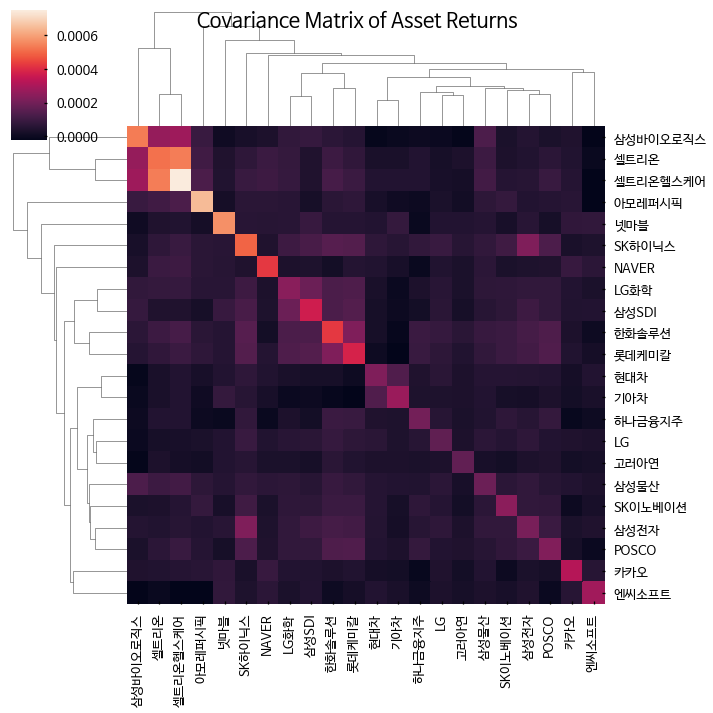

In [14]:
plt.figure(figsize=(7, 7))
g = sns.clustermap(V)
g.fig.suptitle('Covariance Matrix of Asset Returns', fontsize = 20)
plt.show()

### step0 Correlation을 Distance 개념으로 변환하기
We can get $NxN$ distance matrix by converting correlation matrix to $NxN$ matrix $D$ whose item defined as
$d_{i, j} = \sqrt{2(1-\rho_{i, j})}$

In [15]:
correlation_matrix = stock_returns.corr(method='pearson')
# 거리는 양수 책에서는 이것의 제곱형태로 되어있음 그래서 아래에 제곱값으로 넣음
distances = np.sqrt((1 - correlation_matrix) / 2)

### step1 Tree clustering 하기

By default, HRP uses single linkage but any other technique implemented in scipy could do the job. The user can test various clustering method and see which one is the most robust for his particular task. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

Note: The weights have changed a little bit compared to the single linkage method used in the Basic example section.

In [16]:
clusters1 = linkage(squareform(distances), method="single")
pd.DataFrame(clusters1, columns=['cluster_id_1', 'cluster_id_2', 'distance', 'number of members'],
             index=["cluster_{}".format(i+1) for i in range(clusters1.shape[0])])


,cluster_id_1,cluster_id_2,distance,number of members
cluster_1,4.0,13.0,0.260317,2.0
cluster_2,0.0,1.0,0.387731,2.0
cluster_3,5.0,12.0,0.430349,2.0
cluster_4,2.0,3.0,0.470258,2.0
cluster_5,11.0,21.0,0.472284,2.0
cluster_6,9.0,22.0,0.498123,3.0
cluster_7,6.0,26.0,0.517580,3.0
cluster_8,24.0,28.0,0.529235,5.0
cluster_9,23.0,29.0,0.531968,7.0
cluster_10,7.0,27.0,0.540554,4.0


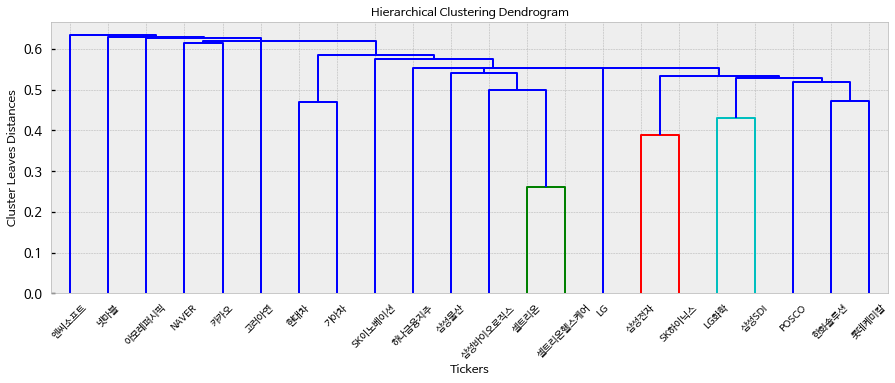

In [17]:
# 그림그리기
plt.figure(figsize=(15, 5))
dendrogram(clusters1, labels=stock_returns.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()

### # Step-2: 순서 재배열하기

<Figure size 504x504 with 0 Axes>

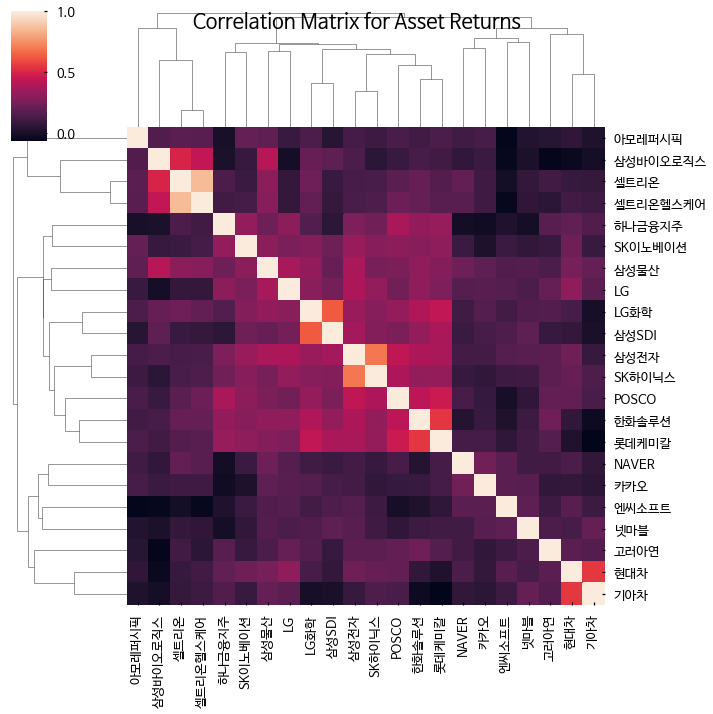

In [18]:
plt.figure(figsize=(7, 7))
g = sns.clustermap(correlation_matrix)
g.fig.suptitle('Correlation Matrix for Asset Returns', fontsize = 20)
plt.show()

### Step-3: Recursive Bisection : Weight 구하기


In [19]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_returns=stock_returns, resample_by='W')
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)

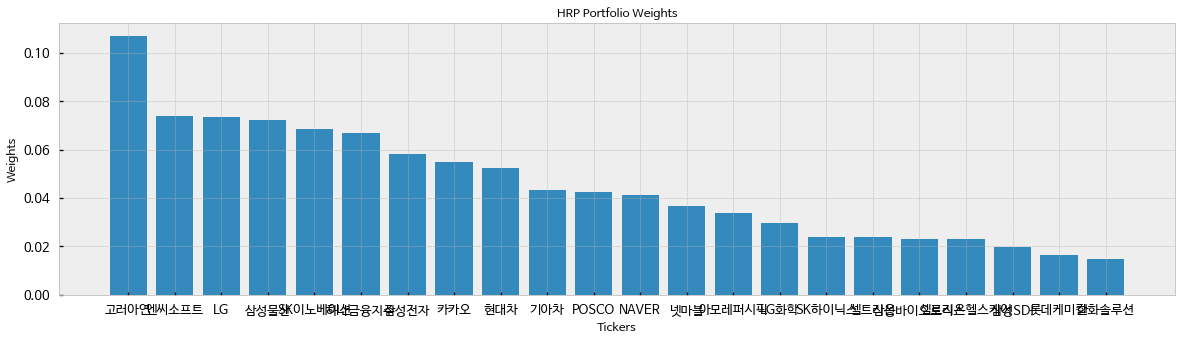

In [20]:
plt.figure(figsize=(20, 5))
plt.bar(hrp_weights.columns, hrp_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('HRP Portfolio Weights', fontsize=12)
plt.show()

#### 참고 Is it possible to build a Long/Short portfolio ?
By using the side_weights parameter (pd.Series) with 1 for Buy and -1 for Sell and asset names as index.

In [21]:
side_weights = pd.Series([1]*prices.shape[1], index=prices.columns)
#Short the first 4 stocks
side_weights.loc[prices.columns[:4]] = -1
side_weights

삼성전자       -1
SK하이닉스     -1
현대차        -1
기아차        -1
셀트리온        1
LG화학        1
POSCO       1
삼성물산        1
NAVER       1
삼성바이오로직스    1
하나금융지주      1
한화솔루션       1
삼성SDI       1
셀트리온헬스케어    1
카카오         1
엔씨소프트       1
LG          1
아모레퍼시픽      1
SK이노베이션     1
넷마블         1
고러아연        1
롯데케미칼       1
dtype: int64

In [22]:
hrp.allocate(asset_returns=stock_returns, resample_by='W', side_weights=side_weights)
hrp_weights1 = hrp.weights.sort_values(by=0, ascending=False, axis=1)

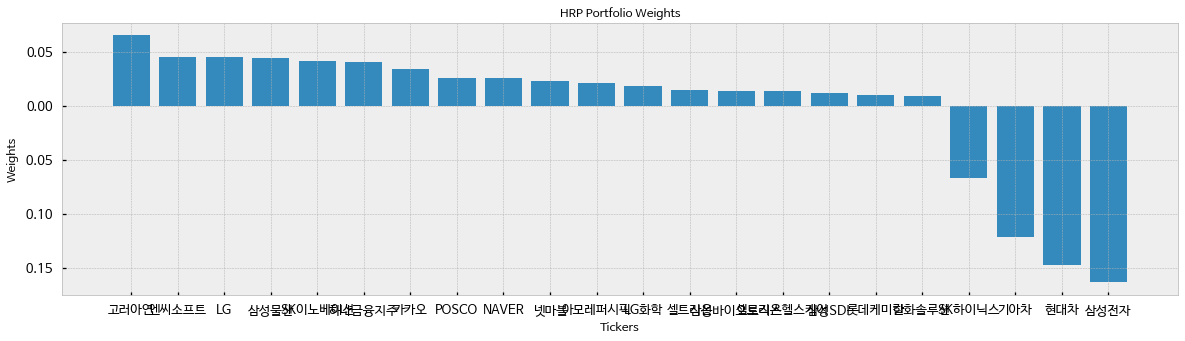

In [23]:
plt.figure(figsize=(20, 5))
plt.bar(hrp_weights1.columns, hrp_weights1.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('HRP Portfolio Weights', fontsize=12)
plt.show()

In [24]:
short_ptf = side_weights[side_weights == -1].index
buy_ptf = side_weights[side_weights == 1].index
weights = hrp.weights.T
print('Proportion $ allocated to short portf:', weights.loc[short_ptf].sum().item())
print('Proportion $ allocated to buy portf:', weights.loc[buy_ptf].sum().item())

Proportion $ allocated to short portf: -0.5
Proportion $ allocated to buy portf: 0.49999999999999994


In [27]:
del KRX

In [25]:
del clusters1
del correlation_matrix
del distances
del prices
del df_list

___
# 섹터 정보를 활용한 포트폴리오 그래프 그려보기

In [21]:
from utils import compute_log_returns, convert_to_distance_matrix, get_condensed_distance_matrix
correlation_matrix = stock_returns.corr(method='pearson')
distance_matrix = convert_to_distance_matrix(correlation_matrix)
#이때 distance matrix 만드는 공식이 살짝 다름

In [22]:
clusters = linkage(squareform(distance_matrix), method="single")
pd.DataFrame(clusters, columns=['cluster_id_1', 'cluster_id_2', 'distance', 'number of members'],
             index=[ "cluster_{}".format(i+1) for i in range(clusters.shape[0])]
            )

,cluster_id_1,cluster_id_2,distance,number of members
cluster_1,4.0,13.0,0.520633,2.0
cluster_2,0.0,1.0,0.775462,2.0
cluster_3,5.0,12.0,0.860698,2.0
cluster_4,2.0,3.0,0.940516,2.0
cluster_5,11.0,21.0,0.944568,2.0
cluster_6,9.0,22.0,0.996247,3.0
cluster_7,6.0,26.0,1.035161,3.0
cluster_8,24.0,28.0,1.058470,5.0
cluster_9,23.0,29.0,1.063936,7.0
cluster_10,7.0,27.0,1.081108,4.0


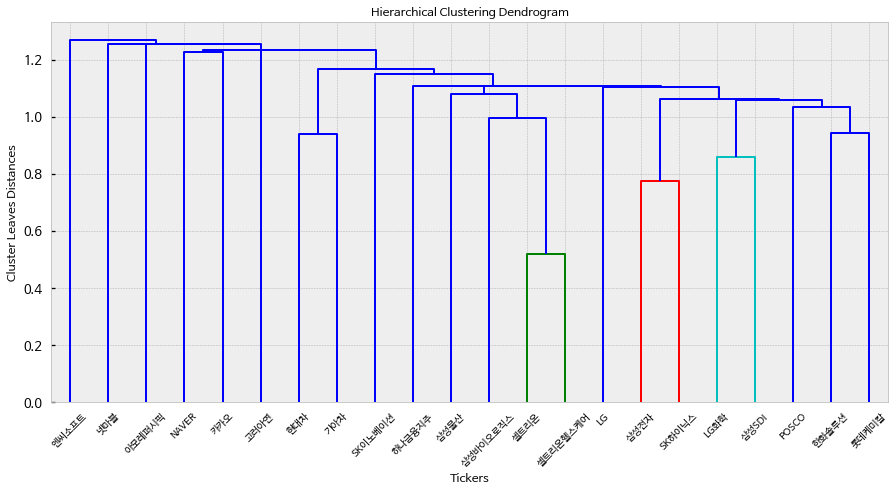

In [23]:
plt.figure(figsize=(15, 7))
dendrogram(clusters, labels=stock_returns.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()

In [ ]:
@엣지 만들때 쓰는녀석

In [24]:
pairs =list(itertools.combinations(Name, 2)) 
edges = []
for a, b in pairs:
    edges.append((distance_matrix.loc[a,b], a, b))

In [25]:
edges.sort()

In [ ]:
@미니멈 스패닝 트리 변형시켜서 다른 거 만들때 쓰기

In [26]:
from mst import MinimumSpanningTree
mst = MinimumSpanningTree(Name, edges)
tree = mst.build()

The building of tree is completed


In [27]:
tree

[(0.5206333663775435, '셀트리온', '셀트리온헬스케어'),
 (0.7754624744430042, '삼성전자', 'SK하이닉스'),
 (0.8606982141342481, 'LG화학', '삼성SDI'),
 (0.9405164350566182, '현대차', '기아차'),
 (0.9445675951505503, '한화솔루션', '롯데케미칼'),
 (0.9962468275865266, '셀트리온', '삼성바이오로직스'),
 (1.0351608859497203, 'POSCO', '롯데케미칼'),
 (1.0584703087813625, 'LG화학', '롯데케미칼'),
 (1.0639359657144123, '삼성전자', 'POSCO'),
 (1.0811076857746196, '삼성물산', '삼성바이오로직스'),
 (1.1060865798415485, '삼성전자', 'LG'),
 (1.1072954825034993, '삼성전자', '삼성물산'),
 (1.1076196322372964, 'POSCO', '하나금융지주'),
 (1.149629117545361, '삼성전자', 'SK이노베이션'),
 (1.1678781378033318, '현대차', 'LG'),
 (1.2284240517735439, 'NAVER', '카카오'),
 (1.235511784926054, '한화솔루션', '고러아연'),
 (1.236101034077967, '삼성물산', 'NAVER'),
 (1.2544380880751582, '아모레퍼시픽', 'SK이노베이션'),
 (1.2570328180973855, '기아차', '넷마블'),
 (1.2694581303846726, '엔씨소프트', '넷마블')]

In [28]:
NUM_CLUSTER=len(sector_index) 
cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)

In [29]:
from graph import build_graph, draw_graph
G = build_graph(Name, tree)

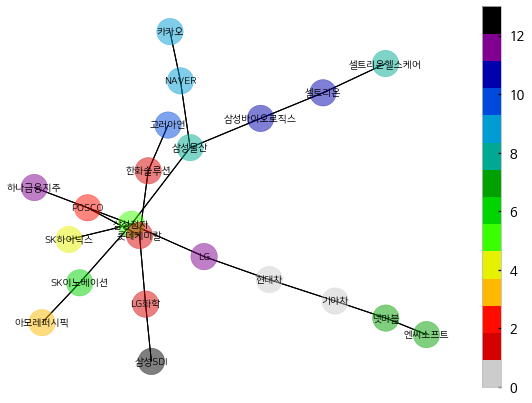

기업군1: 자동차용 엔진 및 자동차 제조업: 기아차, 현대차
기업군2: 기초 화학물질 제조업: LG화학, 롯데케미칼, 한화솔루션
기업군3: 1차 철강 제조업: POSCO
기업군4: 기타 화학제품 제조업: 아모레퍼시픽
기업군5: 반도체 제조업: SK하이닉스
기업군6: 통신 및 방송 장비 제조업: 삼성전자
기업군7: 석유 정제품 제조업: SK이노베이션
기업군8: 소프트웨어 개발 및 공급업: 넷마블, 엔씨소프트
기업군9: 기타 전문 도매업: 삼성물산, 셀트리온헬스케어
기업군10: 자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업: NAVER, 카카오
기업군11: 1차 비철금속 제조업: 고려아연
기업군12: 기초 의약물질 및 생물학적 제제 제조업: 삼성바이오로직스, 셀트리온
기업군13: 기타 금융업: LG, 하나금융지주
기업군14: 일차전지 및 축전지 제조업: 삼성SDI


In [31]:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=NUM_CLUSTER-1))
plt.colorbar(sm)
draw_graph(G, sector_info, cmap, label=False)
for sector_name, index in sector_index.items():
    print(f"기업군{index+1}: {sector_name}: {', '.join(portfolio[portfolio['Sector']==sector_name]['Name'])}")